# **Data Science projet SS2021**

Author: **Robin Ringwald**

course of study: **MMR**

Topic: **Retail Product Categorisation**

Kaggle name: **Rob Top**

Kaggle score: **0.84964**


This notebook is created for the Data Science project in summer 2021. It is oriented mostly on the workflow from the lecture seen below and based on the given solution.






0. **Start:** Hypethesis

1. Collect Data

2. Exploratory Data Analytics (EDA)

  *   Visualize
  *   Pre-process
  *   clean

3. Model building

4. Statistic and Evaluation

5. Submission


Implemented Solutions:


*   LSTM Net + MobileNet (Base Solution)
*   BERT + MobileNet
*   BERT + Sequential Keras
*   BERT + GoogleNet



---


Tested were some different types of BERT pre-trained networks, in which the results were not very different.

Already tested BERT-models:

*   small_bert/bert_en_uncased_L-2_H-768_A-12 (duration per epoch: approx. **2,5 min.**, result: **0,83X**)
*   small_bert/bert_en_uncased_L-4_H-512_A-8 (duration per epoch: approx. **4 min.**, result: **0,84X**)

    Duration very much depends on the GPU, which is provided by Colab, in example:

    *   Tesla K80: 7.5 min. per epoch
    *   Tesla P100: 4 min per epoch

*   small_bert/bert_en_uncased_L-4_H-768_A-12 (duration per epoch: approx. **6,5 min.**, result: **0,84X**)

*   small_bert/bert_en_uncased_L-12_H-512_A-8 (duration per epoch: approx. **8 min.**, result: **0,83X**)



---



The best result so far was achieved with **BERT** for text classification in combination with **sequential keras** for image classification. 

# 0 Hypothesis



The project deals with a Kaggle competition created specifically for the lecture. This competition is for product classification based on pictures and descriptions of the products.
The data is made available in the Kaggle competition. It is planned to carry out the project in Colab with the help of a GPU.

Have a look at current GPU in Colab

In [ ]:
!nvidia-smi

Fri Aug 13 14:30:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1 Collect Data

## 1.1 Import the necessary libraries and make initializations

In [ ]:
! pip install keras_metrics
! pip install tabulate

In [ ]:
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd #needed for value handling
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')  #commonly used words
stop_english=set(stopwords.words('english'))
from gensim.models.wrappers import FastText
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#import cv2
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline


from IPython.display import display
from tabulate import tabulate
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import models
from tensorflow.keras import layers
import PIL
from tensorflow import keras
from tensorflow.keras.models import Sequential

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1.2 Import the competition Data from Kaggle

Upload kaggle.json to colab from local computer and copy to root directory.

Detailed guide: https://www.kaggle.com/general/74235

In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


load Data set from Kaggle and unzip it to colab directory.

In [ ]:
! pip install --upgrade --force-reinstall --no-deps kaggle &> /dev/null   # &> /dev/null hides the cell-output of this line, errors that may rise, still will be shown
! kaggle datasets list &> /dev/null
! kaggle competitions download -c 'retail-products-classification'
! mkdir retail-products-classification &> /dev/null
! unzip retail-products-classification.zip -d retail-products-classification &> /dev/null

 99% 257M/259M [00:02<00:00, 140MB/s]
100% 259M/259M [00:02<00:00, 105MB/s]


## 1.3 Read and Prepare Data

Read the train.csv file 

In [ ]:
data = pd.read_csv('retail-products-classification/train.csv')

List of classes

Parameters

In [ ]:
CATEGORIES = ['Electronics', 'Sports & Outdoors',
       'Cell Phones & Accessories', 'Automotive', 'Toys & Games',
       'Tools & Home Improvement', 'Health & Personal Care', 'Beauty',
       'Grocery & Gourmet Food', 'Office Products',
       'Arts, Crafts & Sewing', 'Pet Supplies', 'Patio, Lawn & Garden',
       'Clothing, Shoes & Jewelry', 'Baby',
       'Musical Instruments', 'Industrial & Scientific', 'Baby Products',
       'Appliances', 'All Beauty', 'All Electronics']

In [ ]:
train_images_path = 'retail-products-classification/train/train'
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 30
VALIDATION_SPLIT = .2
NUM_CLASSES = len(CATEGORIES)
L2_REGULARIZATION = 0.01

Preparation to download the images for the train dataset

In [ ]:
downloaded_files = []
for file in os.listdir(train_images_path):
    if file.endswith(".jpg"):
        downloaded_files.append(file.replace(".jpg", ""))
print(len(downloaded_files))

42000


In [ ]:
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

# 2 Exploratory Data Analytics

## 2.1 Visualize

Visualize some Data itself and some images. Additionally visualize some information about the Dataset to get it better known.



### 2.1.1 Visualize some data

As always, first have a look at the header of the dataset. The header gives a good first overview of the data we are facing.

In [ ]:
data.head()

ImgId  ...                 categories
0  B000HYL1V6  ...      Arts, Crafts & Sewing
1  B00006HXWY  ...  Cell Phones & Accessories
2  B000GAWSBS  ...  Clothing, Shoes & Jewelry
3  B000040JOL  ...   Tools & Home Improvement
4  B00006IB78  ...     Health & Personal Care

[5 rows x 4 columns]

In [ ]:
print(tabulate(data['categories'].value_counts().to_frame(),headers=["categories", "Number of items"], tablefmt='fancy_grid'))

# Alternatives

#data['categories'].value_counts().plot(kind='bar', figsize=(14, 5));
#data['categories'].value_counts().to_frame()#.columns=["categories", "Number of items"]


╒═══════════════════════════╤═══════════════════╕
│ categories                │   Number of items │
╞═══════════════════════════╪═══════════════════╡
│ Arts, Crafts & Sewing     │              2225 │
├───────────────────────────┼───────────────────┤
│ Beauty                    │              2202 │
├───────────────────────────┼───────────────────┤
│ Grocery & Gourmet Food    │              2201 │
├───────────────────────────┼───────────────────┤
│ Sports & Outdoors         │              2201 │
├───────────────────────────┼───────────────────┤
│ All Electronics           │              2200 │
├───────────────────────────┼───────────────────┤
│ Baby Products             │              2200 │
├───────────────────────────┼───────────────────┤
│ All Beauty                │              2200 │
├───────────────────────────┼───────────────────┤
│ Musical Instruments       │              2200 │
├───────────────────────────┼───────────────────┤
│ Patio, Lawn & Garden      │              2200 │


### 2.1.2 Visualize some Images of the Data set

In [ ]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('retail-products-classification/train/train/*.jpg'): #assuming .jpg
    im=Image.open(filename)
    image_list.append(im)

iterations:  30


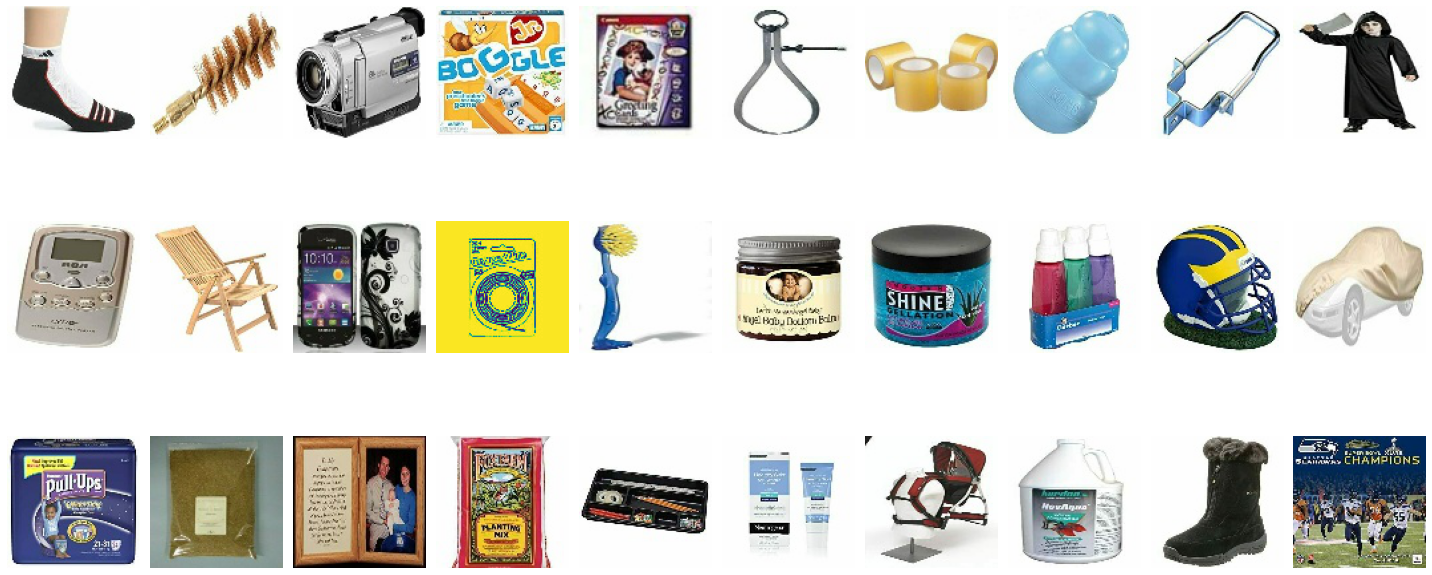

In [ ]:
j = 1   # counter for loop iterations
rows = 3
columns = 10
stepsize = 1000

fig = plt.subplots(rows, columns, figsize=(20,10))

# eventuell noch die jeweilige Kategorie als title
for i in range(1,(rows*columns*stepsize),stepsize):
    plt.subplot(rows,columns,j)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image_list[i])
    j += 1

plt.tight_layout()
print('iterations: ', j-1)

### 2.1.3 Visualize some information about the Data set

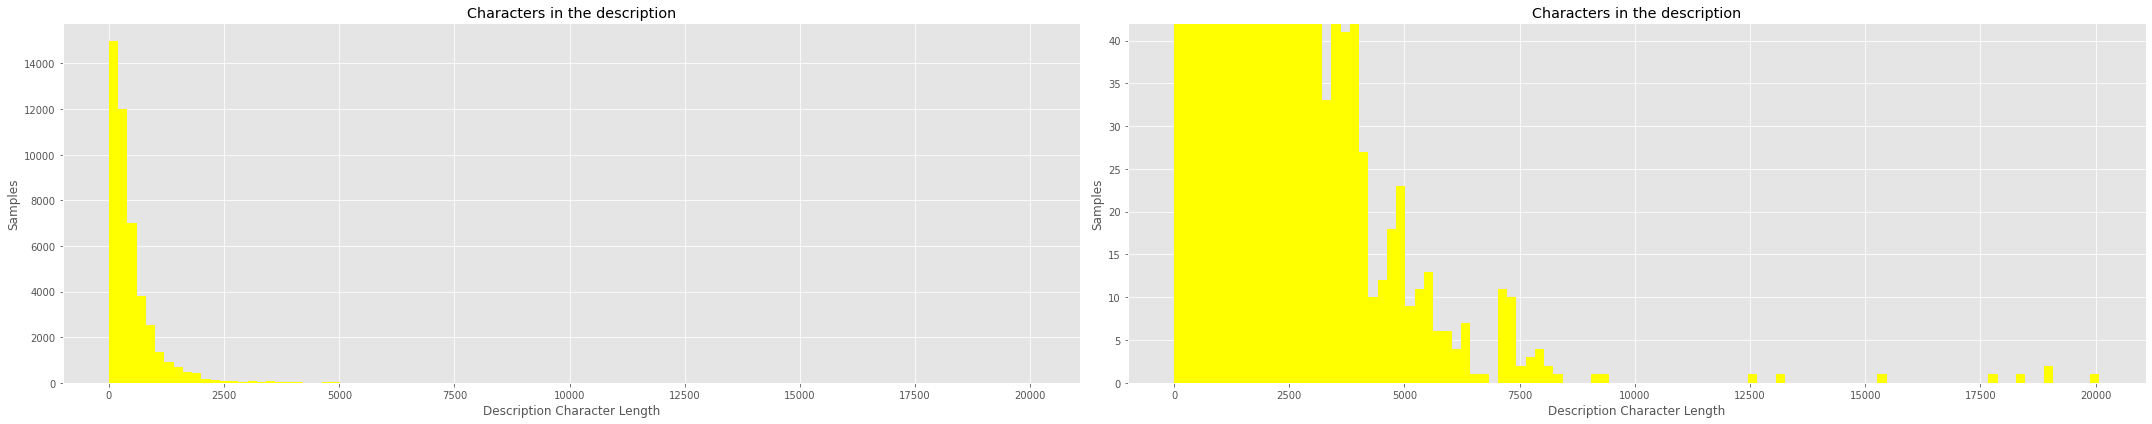

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))


word_len=data['description'].str.len()
axs[0].hist(word_len, bins=100, color = "yellow")
axs[0].set_ylabel('Samples')
axs[0].set_xlabel('Description Character Length')
axs[0].set_title('Characters in the description')

axs[1].set_ylim([0, 42])

word_len=data['description'].str.len()
axs[1].hist(word_len, bins=100, color = "yellow")
axs[1].set_ylabel('Samples')
axs[1].set_xlabel('Description Character Length')
axs[1].set_title('Characters in the description')


plt.tight_layout()

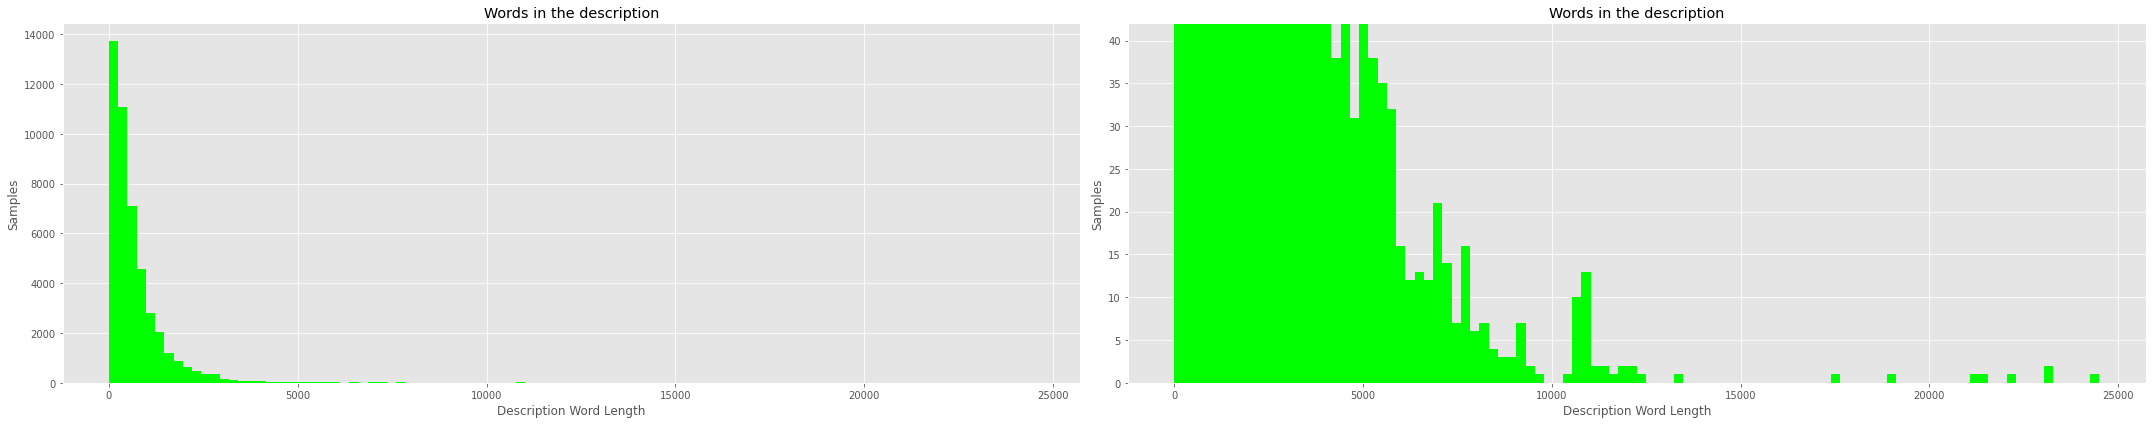

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))

word_len=data['description'].str.split().map(lambda x: len(str(x)))
axs[0].hist(word_len, bins=100, color = "lime")
axs[0].set_ylabel('Samples')
axs[0].set_xlabel('Description Word Length')
axs[0].set_title('Words in the description')

axs[1].set_ylim([0, 42])

word_len=data['description'].str.split().map(lambda x: len(str(x)))
axs[1].hist(word_len, bins=100, color = "lime")
axs[1].set_ylabel('Samples')
axs[1].set_xlabel('Description Word Length')
axs[1].set_title('Words in the description')

plt.tight_layout()

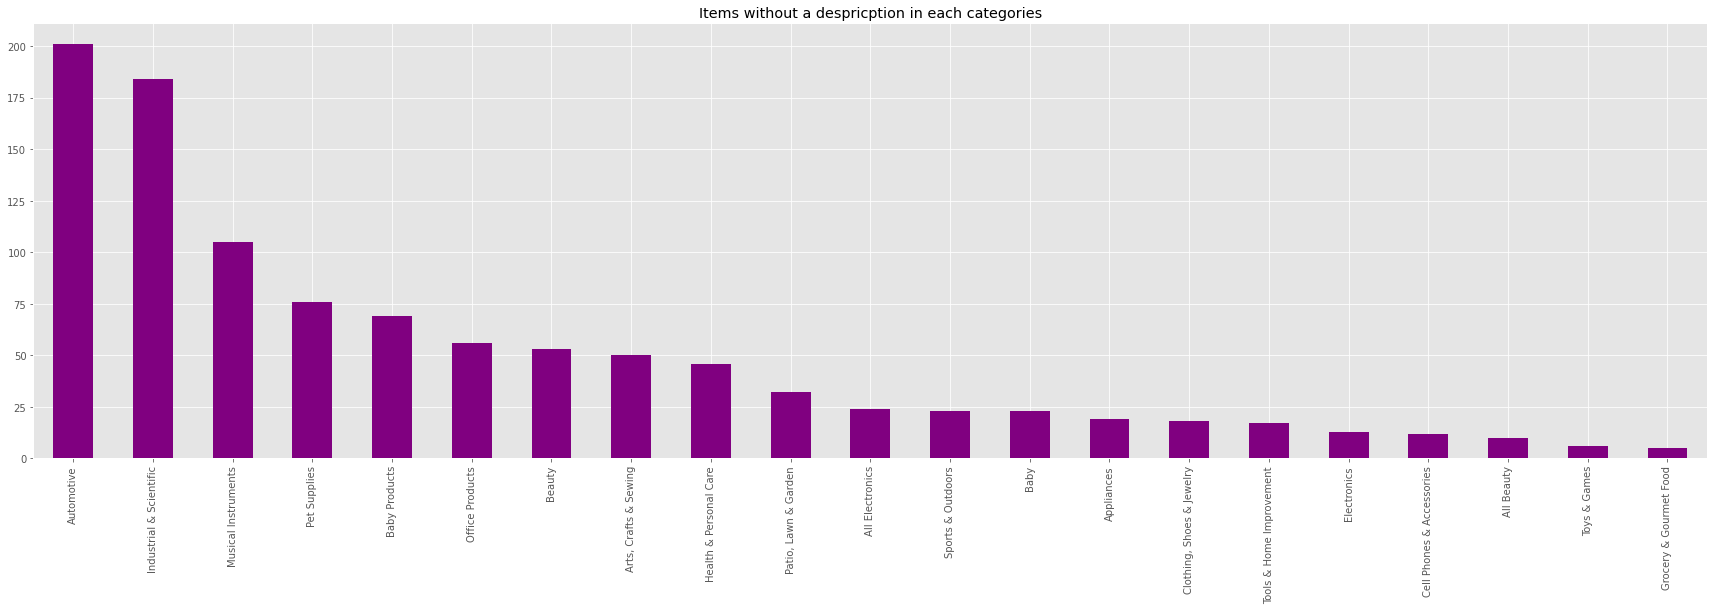

In [ ]:
d_NaN = data[data['description'].isnull()]
d_NaN['categories'].value_counts().plot(kind='bar',figsize=(30,8),color='purple', title='Items without a despricption in each categories')

### 2.1.4 Conclusion of visualization




*   One Data set got an Image ID, title, description and the categorie
*   The categories have all about the same number of products
*   A small percentage of the products have a very long description
*   There are items in each category without a description

Approach: 
 

*   Pre-process the description and remove redundant information and reduce it to a minimum.
*   Normalize the images, to same format.








## 2.2 Pre-process

Clean the text data and normalize the images.

### 2.2.1 Text preprocessing

In [ ]:
def get_token(description):
        # split the description into tokens (words)
        tokens = set(gensim.utils.tokenize(description))
        # Avoid words does not have atleast 2 character 
        tokens = [i for i in tokens if(len(i) > 2)]
        # Remove stop words
        tokens = [s for s in tokens if s not in stop_english]
        return tokens

Filter special characters from the description, such as numbers and special characters.
In Addition convert all characters to lower case.

Remove words with less then 2 characters and english stop words such as: i, me, myself, we...

In [ ]:
def filter_description (text_data):
    data_words = tf.keras.preprocessing.text.text_to_word_sequence(
          text_data,
          filters='!"#$%&()*+,-./:;\<=>?@[\\]^_`{|}~\t\n1234567890',
          lower=True,
          split=' ' 
        )
    #filter short words with less then 2 characters
    data_words = [i for i in data_words if(len(i) > 2)]
    # Remove stop words
    data_words = [s for s in data_words if s not in stop_english]
    #Just use the first 250 Words of the description
    del data_words[256:]
    # Put the single words back in sentences
    listToStr = ' '.join([str(elem) for elem in data_words])
     #put the strings together
    filters="',"
    for x in range(len(filters)):
        text_fil= listToStr.replace(filters[x],"")
    #return data_words  
    return text_fil

### 2.2.2 Image preprocessing

In [ ]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

### 2.2.3 Read product images
Read all the product images from the train folder and get corresponding description from the csv file. Data should labeled by its category.

In [ ]:
corpus = []
images = []
labels = []
image_id = []
files = os.listdir(train_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images.append(img_array.astype('float32'))
                token_list = get_token(str(title) + ' ' + str(description))
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
                image_id.append(index)
        except IndexError as error:
            print(error)

images = np.asarray(images)
labels = pd.get_dummies(labels).values
images = preprocess_input(images)

In [ ]:
MAX_LEN=40
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

### FastText pretrained vectors
[Download](https://fasttext.cc/docs/en/crawl-vectors.html) and load FastText pretrained vectors. Otherwise use the gensim to load the fasttext model. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. Then initilize the embedding matrix with fastText word vectors.

In [ ]:
import gensim.downloader as api
model_fasttext = api.load("fasttext-wiki-news-subwords-300")
known_words = []
unknown_words = []
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    if word in model_fasttext:
        known_words.append(word)
        embedding_matrix[i] = model_fasttext.wv[word]
    else:
        unknown_words.append(word)
        

[==================================================] 100.0% 958.5/958.4MB downloaded


  0%|          | 0/72350 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 72350/72350 [00:00<00:00, 205487.30it/s]


In [ ]:
print(len(unknown_words))
print(len(known_words))
del model_fasttext

31996
40354


# 3 Model building

## 3.1 Text Classification

### 3.1.1 BERT Text Classification

based on Tensorflow Example:

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb

In [ ]:
# preparation BERT
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

import shutil

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

     |████████████████████████████████| 4.3 MB 10.9 MB/s 
     |████████████████████████████████| 1.6 MB 11.4 MB/s 
     |████████████████████████████████| 211 kB 52.4 MB/s 
     |████████████████████████████████| 1.2 MB 47.4 MB/s 
     |████████████████████████████████| 636 kB 62.5 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 352 kB 47.6 MB/s 
     |████████████████████████████████| 90 kB 9.3 MB/s 
     |████████████████████████████████| 99 kB 8.5 MB/s 
     |████████████████████████████████| 37.1 MB 75 kB/s 
     |████████████████████████████████| 679 kB 68.8 MB/s 


#### Create Dataset for BERT model

In [ ]:
#duration approx. 3 min
corpus = []
images = []
labels = []
image_id = []
#get a list of all files in the directory
files = os.listdir(train_images_path)
random.shuffle(files)

#iterate trough every single image in the list files
for img in files:
    #get the id of the image by removing the .jpeg
    img_id = img.split('.')[0]
    #create the image(size 80x80, rgb, convert into array)
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            #read the data of the image in the row with the image id
            index = data[data['ImgId']==img_id].index.values[0]
            #write the data into row
            row = data.iloc[index , :]
            #family = category of the image
            family = row[3]
            #if the family of the products is in the define categories
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                #adds an item to the end of the list images
                images.append(img_array.astype('float32'))
                #get a list with all tokens (words) in the description and title, own prefiltering 
                token_list = filter_description(str(title) + ' ' + str(description))#changed
                #adds the words of the current token_list to the corpus (Textsammlung)
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
                image_id.append(index)
        except IndexError as error:
            print(error)

#converting
#corpus = alle Beschreibungen 
images = np.asarray(images)
labels = pd.get_dummies(labels).values  #on hot encoded labels
images = preprocess_input(images)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [ ]:
#Train test Split:
p = int((len(image_id)*80)/100)

#train data
train_data_raw = corpus[:p]
train_labels_onehot = labels[:p]
#test data
test_data_raw = corpus[p:]
test_labels_onehot = labels[p:]

print('train data:',len(train_data_raw))
print('train labels:',len(train_labels_onehot))
print('test data:',len(test_data_raw))
print('test_labels:',len(test_labels_onehot))

train data: 33600
train labels: 33600
test data: 8400
test_labels: 8400


In [ ]:
#create a Dataset, shuffel and prefetch it, to speed up the training
train_ds = tf.data.Dataset.from_tensor_slices((train_data_raw,train_labels_onehot))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_data_raw,test_labels_onehot))
test_ds = test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Already tested BERT-models:

*   small_bert/bert_en_uncased_L-2_H-768_A-12 (duration per epoch: approx. **2,5 min.**, result: **0,8XX**)
*   small_bert/bert_en_uncased_L-4_H-512_A-8 (duration per epoch: approx. **4 min.**, result: **0,8XX**)

    Duration very much depends on the GPU, which is provided by Colab.

    *   Tesla K80: 7.5 min. per epoch
    *   Tesla P100: 4 min per epoch

*   small_bert/bert_en_uncased_L-4_H-768_A-12 (duration per epoch: approx. **6,5 min.**, result: **0,8XX**)

*   small_bert/bert_en_uncased_L-12_H-512_A-8 (duration per epoch: approx. **8 min.**, result: **0,8XX**)









In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### The preprocessing mode

Test preprocessing

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#### Using the BERT model

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611856  0.36673826  0.15233693  0.65504473
  0.9681154  -0.94862705  0.0021619  -0.9877732   0.06842698 -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946355  0.34321284  0.3323149  ...  0.21300808  0.71020824
  -0.05771172]
 [-0.2874203   0.31981018 -0.2301853  ...  0.58455014 -0.21329692
   0.7269214 ]
 [-0.66157     0.6887689  -0.8743298  ...  0.10877271 -0.26173168
   0.47855347]
 ...
 [-0.22561166 -0.28925633 -0.07064366 ...  0.47566074  0.83277154
   0.4002533 ]
 [-0.29824263 -0.2747314  -0.05450518 ...  0.48849723  1.095536
   0.18163356]
 [-0.443782    0.00930692  0.07223746 ...  0.17290054  1.1833245
   0.07897988]]


#### Define your model

Model for use only with text classification

In [ ]:
# very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(21, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
# Let's check that the model runs with the output of the preprocessing model.

BERT_Text_classification_model = build_classifier_model()
bert_raw_result = BERT_Text_classification_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.7405214  0.40432572 0.2116593  0.5541287  0.36156446 0.29260495
  0.38225487 0.86373234 0.46556738 0.4438991  0.4313671  0.50450546
  0.726978   0.06649002 0.48900482 0.62440443 0.42814067 0.10238983
  0.23500109 0.5742978  0.607015  ]], shape=(1, 21), dtype=float32)


Model for use with another model for image classification to combine both

In [ ]:
def build_BERT_classifier():
      text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
      preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing',trainable=False)
      encoder_inputs = preprocessing_layer(text_input)
      encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
      outputs = encoder(encoder_inputs)
      net = outputs['pooled_output']
      net = tf.keras.layers.Dropout(0.2)(net)
      net = tf.keras.layers.Dense(2048,activation='relu')(net)
      return tf.keras.Model(text_input, net)

In [ ]:
BERT_model = build_BERT_classifier()
BERT_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  38603521    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

#### Model Structure

In [ ]:
BERT_Text_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'default': (None, 5 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

Print the Layout of the current defined BERT-model as a flowchart

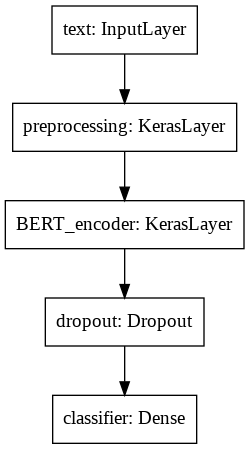

In [ ]:
tf.keras.utils.plot_model(BERT_Text_classification_model)

#### Model Training

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()


Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

For the learning rate (init_lr), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).


In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_Text_classification_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = BERT_Text_classification_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
1050/1050 [==============================] - 464s 435ms/step - loss: 0.2029 - binary_accuracy: 0.9420 - val_loss: 0.0900 - val_binary_accuracy: 0.9680
Epoch 2/10
1050/1050 [==============================] - 456s 434ms/step - loss: 0.0756 - binary_accuracy: 0.9730 - val_loss: 0.0643 - val_binary_accuracy: 0.9775
Epoch 3/10
1050/1050 [==============================] - 455s 434ms/step - loss: 0.0526 - binary_accuracy: 0.9814 - val_loss: 0.0573 - val_binary_accuracy: 0.9809
Epoch 4/10
1050/1050 [==============================] - 457s 435ms/step - loss: 0.0396 - binary_accuracy: 0.9863 - val_loss: 0.0553 - val_binary_accuracy: 0.9821
Epoch 5/10
1050/1050 [==============================] - 456s 434ms/step - loss: 0.0301 - binary_accuracy: 0.9899 - val_loss: 0.0549 - val_binary_accuracy: 0.9830
Epoch 6/10
1050/1050 [==============================] - 457s 436ms/step - loss: 0.0232 - binary_ac

#### Results on  Text Classification with only BERT

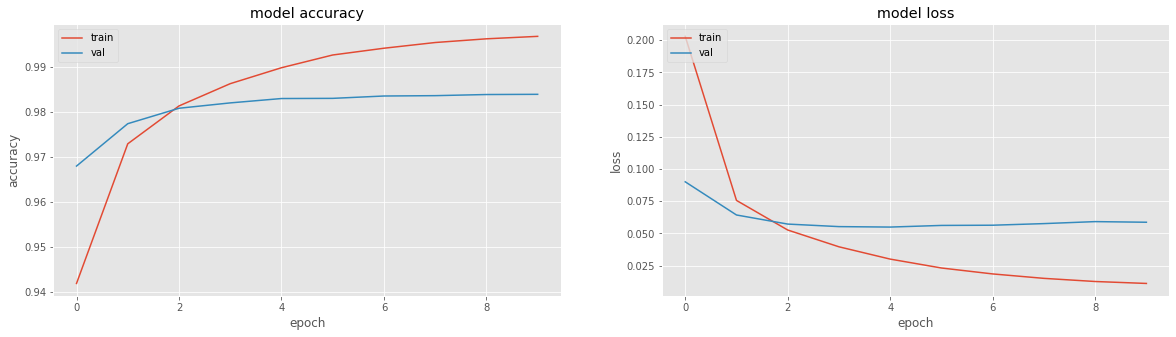

In [ ]:
history_bert = history.history
fig, axes = plt.subplots(1, 2, figsize=(20,5))

#Plot the accuracy
axes[0].plot(history_bert['binary_accuracy'])
axes[0].plot(history_bert['val_binary_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')


#Plot the loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')

Create Submission File

In [ ]:
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head()

ImgId  ...                                        description
0  B0006IK25E  ...  Jacquard Textile Pink Color in 2.25 ounces can...
1  B000GBRO16  ...  Fimo Soft Polymer Clay is easier to use than b...
2  B000H6OZGW  ...  Sculpey 3 Polymer Clay is America's original o...
3  B000BR28KC  ...  Handmade since 1900 Sennelier extra-fine soft ...
4  B0006IK27M  ...  JACQUARD TEXTILE COLORS FABRIC PAINT - These e...

[5 rows x 3 columns]

In [ ]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [ ]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(filter_description(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

test_ds_submission = tf.data.Dataset.from_tensor_slices(test_corpus)
test_ds_submission = test_ds_submission.batch(BATCH_SIZE)
test_ds_submission = test_ds_submission.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
pred_submission = BERT_Text_classification_model.predict(test_ds_submission)
test_classes = np.argmax(pred_submission, axis = 1)
print(test_classes)
print(test_classes.shape)

[ 1 12  8 ...  6 10  6]
(6367,)


In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])

### 3.2.2 LSTM Net Text Classification

In [ ]:
# Original model from base solution

embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN,trainable=False)

dropout = tf.keras.layers.SpatialDropout1D(0.2)
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
dense = tf.keras.layers.Dense(200, activation='relu')
embedding_model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    lstm,
    dense 
])
embedding_model.summary()'


## 3.2 Image Classification

In this chapter, different pre-trained models for image classification are loaded. These models are later concatenated with a model for text classification.

In [ ]:
# set the requiered settings for model building
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = len(CATEGORIES)

### 3.2.1 MobileNet

In [ ]:
# Original model from base solution
input_tensor = Input(shape=INPUT_SHAPE)
MobileNet_Image_classification_model = MobileNet(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)
output = tf.keras.layers.Reshape((4096,))(MobileNet_Image_classification_model.output)
output = tf.keras.layers.Dense(100, activation='relu')(output)
MobileNet_Image_classification_model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/d

### 3.2.2 Sequential Keras

Load pretrained sequential keras model.

detailed guide: https://www.tensorflow.org/tutorials/images/classification

In [ ]:
img_height = 80
img_width = 80

In [ ]:
num_classes = 5

Sequential_keras_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 3.2.3 GoogleNet

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor,
                      input_shape=(80, 80, 3), pooling=None)

print(model.summary())

modelIncep = models.Sequential()
modelIncep.add(model)
modelIncep.add(layers.Flatten())
modelIncep.add(layers.Dense(NUM_CLASSES, activation='relu'))

model.trainable = False
print(modelIncep.summary())

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 39, 39, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 39, 39, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 39, 39, 32)   0           batch_normalization[0][0]        
______________________

## 3.3 Concatenate both models
Finally, we concatenate the output of both image and text classification model for interpretation and ultimate prediction. The functional API provided by Keras will help to build complex models with multiple output/input. We have used the Keras concatenate class to merge the result of both models. It takes a list of tensors, all are of the same shape as input and returns a single tensor which is the concatenation of all inputs. The concatenated output connects to the dense layer with softmax classifier. We have used the output layer to extract the embedding.

In [ ]:
del final_model

In [ ]:
# BERT and MobileNet

merged = tf.keras.layers.Concatenate()([BERT_model.output, output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense1 = tf.keras.layers.Dense(100, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense1)

final_model = tf.keras.Model(inputs=[BERT_model.input, MobileNet_Image_classification_model.input], outputs=output_layer)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localh

In [ ]:
# BERT and Sequential Keras

merged = tf.keras.layers.Concatenate()([BERT_model.output, Sequential_keras_model.output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense1 = tf.keras.layers.Dense(100, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense1)

final_model = tf.keras.Model(inputs=[BERT_model.input, Sequential_keras_model.input], outputs=output_layer)

In [ ]:
# BERT and GoogleNet

merged = tf.keras.layers.Concatenate()([BERT_model.output, modelIncep.output])

normalize = tf.keras.layers.BatchNormalization()(merged)

dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout) #final_dropout

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense2)

final_model = tf.keras.Model(inputs=[BERT_model.input, modelIncep.input], outputs=output_layer)

In [ ]:
 Original from base solution

merged = tf.keras.layers.Concatenate()([embedding_model.output, output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(50, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[model.input, embedding_model.input], outputs=output_layer)

In [ ]:
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rescaling_input (InputLayer)    [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 80, 80, 3)    0           rescaling_input[0][0]            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 16)   448         rescaling[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 16)   0           conv2d[0][0]                     
____________________________________________________________________________________________

tf.keras.utils.plot_model(
    final_model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## 3.4 Create test and training Data
Split the complete dataset into 95% data for training and 5% for test. This is changed from the base solution, to get more data for training with the final model.

In [ ]:
CALLBACK_PATIENCE = 10
BATCH_SIZE = 28
NUM_EPOCHS = 11
VALIDATION_SPLIT = .1
L2_REGULARIZATION = 0.01

In [ ]:
#Split the data
p = int((len(images)*95)/100)

#Image Data
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]

#Text Data
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

train_data_raw = corpus[:p]
train_labels_onehot = labels[:p]
test_data_raw = corpus[p:]
test_labels_onehot = labels[p:]

text_train = np.asarray(train_data_raw)
text_test = np.asarray(test_data_raw)

In [ ]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)
print("Shape of Text Train ",text_train.shape)

Shape of train (39900, 80, 80, 3)
Shape of Validation  (2100, 80, 80, 3)
Shape of train (39900, 21)
Shape of Validation  (2100, 21)
Shape of Text Train  (39900,)


## 3.5 Data Augumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            #yield X2i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

In [ ]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
tensorboard = TensorBoard('./logs')
callbacks = [early_stop, reduce_lr, tensorboard]
adam = tf.keras.optimizers.Adam(learning_rate=3e-5)
#optimizer = adam
final_model.compile(optimizer = adam,
              loss='categorical_crossentropy',
              #metrics=['accuracy'])
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

#Precision : TP /(TP+FP)
#Recall: TP/(TP+FN)

## 3.6 Train the final model
Train the final model, which is concaneted of two models, one for image classification and one for text classification.

Depending on which models were concanetad in the previous steps. Different combinations of models were trained, their results are viewed in the following chapter.

### 3.6.2 BERT and MobileNet

BERT: small_bert/bert_en_uncased_L-4_H-512_A-8

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([ text_train,image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test, image_test], label_test))
except RuntimeError as e:
  print(e)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter 

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
1425/1425 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9305 - precision: 0.8505 - recall: 0.7807Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:local

In [ ]:
#final_model.save_weights("saved_model/weights.h5")
#final_model.load_weights("static/weights.h5")

### 3.6.2 BERT and Sequential Keras

#### small_bert/bert_en_uncased_L-2_H-768_A-12

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([ text_train,image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test, image_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/11


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1425/1425 [==============================] - 203s 139ms/step - loss: 1.7013 - accuracy: 0.4948 - precision: 0.5034 - recall: 0.2090 - val_loss: 1.0219 - val_accuracy: 0.6900 - val_precision: 0.6377 - val_recall: 0.4035
Epoch 2/11
1425/1425 [==============================] - 196s 138ms/step - loss: 0.9318 - accuracy: 0.7115 - precision: 0.6758 - recall: 0.4855 - val_loss: 0.8134 - val_accuracy: 0.7586 - val_precision: 0.7145 - val_recall: 0.5512
Epoch 3/11
1425/1425 [==============================] - 196s 137ms/step - loss: 0.6857 - accuracy: 0.7863 - precision: 0.7367 - recall: 0.5951 - val_loss: 0.7311 - val_accuracy: 0.7938 - val_precision: 0.7560 - val_recall: 0.6281
Epoch 4/11
1425/1425 [==============================] - 196s 138ms/step - loss: 0.5170 - accuracy: 0.8363 - precision: 0.7735 - recall: 0.6544 - val_loss: 0.6876 - val_accuracy: 0.8100 - val_precision: 0.7858 - val_recall: 0.6757
Epoch 5/11
1425/1425 [==============================] - 196s 137ms/step - loss: 0.3861 - ac

In [ ]:
#final_model.save_weights("saved_model/weights.h5")
#final_model.load_weights("static/weights.h5")

#### small_bert/bert_en_uncased_L-4_H-512_A-8

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([ text_train,image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test, image_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1425/1425 [==============================] - 202s 139ms/step - loss: 0.4632 - accuracy: 0.8658 - precision: 0.8878 - recall: 0.7225 - val_loss: 0.8211 - val_accuracy: 0.8181 - val_precision: 0.9086 - val_recall: 0.8338
Epoch 2/15
1425/1425 [==============================] - 195s 137ms/step - loss: 0.2503 - accuracy: 0.9226 - precision: 0.9138 - recall: 0.8624 - val_loss: 0.9405 - val_accuracy: 0.8195 - val_precision: 0.9166 - val_recall: 0.8760
Epoch 3/15
1425/1425 [==============================] - 195s 137ms/step - loss: 0.1836 - accuracy: 0.9426 - precision: 0.9221 - recall: 0.8868 - val_loss: 1.0068 - val_accuracy: 0.8048 - val_precision: 0.9265 - val_recall: 0.8946

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136257e-06.
Epoch 4/15
1425/1425 [==============================] - 195s 137ms/step - loss: 0.1014 - accuracy: 0.9689 - precision: 0.9311 - recall: 0.9021 - val_loss: 0.9659 - val_accuracy: 0.8276 - val_precision: 0.9358 - val_recall: 0.9106
Epoch 5/1

In [ ]:
#final_model.save_weights("saved_model/weights.h5")
#final_model.load_weights("static/weights.h5")

#### small_bert/bert_en_uncased_L-4_H-768_A-12

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([ text_train,image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test, image_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/11


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1425/1425 [==============================] - 317s 207ms/step - loss: 1.4712 - accuracy: 0.5570 - precision: 0.5349 - recall: 0.3034 - val_loss: 0.9224 - val_accuracy: 0.7210 - val_precision: 0.6633 - val_recall: 0.4739
Epoch 2/11
1425/1425 [==============================] - 293s 205ms/step - loss: 0.8191 - accuracy: 0.7451 - precision: 0.7000 - recall: 0.5372 - val_loss: 0.7640 - val_accuracy: 0.7705 - val_precision: 0.7305 - val_recall: 0.5826
Epoch 3/11
1425/1425 [==============================] - 292s 205ms/step - loss: 0.5873 - accuracy: 0.8147 - precision: 0.7548 - recall: 0.6210 - val_loss: 0.7570 - val_accuracy: 0.7862 - val_precision: 0.7736 - val_recall: 0.6528
Epoch 4/11
1425/1425 [==============================] - 293s 205ms/step - loss: 0.4279 - accuracy: 0.8649 - precision: 0.7890 - recall: 0.6806 - val_loss: 0.7647 - val_accuracy: 0.7938 - val_precision: 0.8015 - val_recall: 0.7027
Epoch 5/11
1425/1425 [==============================] - 293s 205ms/step - loss: 0.3038 - ac

In [ ]:
#final_model.save_weights("saved_model/weights.h5")
#final_model.load_weights("static/weights.h5")

#### small_bert/bert_en_uncased_L-12_H-512_A-8

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([ text_train,image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test, image_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/11


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1425/1425 [==============================] - 418s 282ms/step - loss: 1.4964 - accuracy: 0.5499 - precision: 0.5128 - recall: 0.2597 - val_loss: 0.9443 - val_accuracy: 0.7195 - val_precision: 0.6618 - val_recall: 0.4419
Epoch 2/11
1425/1425 [==============================] - 398s 279ms/step - loss: 0.8167 - accuracy: 0.7467 - precision: 0.7103 - recall: 0.5188 - val_loss: 0.7857 - val_accuracy: 0.7767 - val_precision: 0.7387 - val_recall: 0.5747
Epoch 3/11
1425/1425 [==============================] - 396s 278ms/step - loss: 0.5896 - accuracy: 0.8167 - precision: 0.7616 - recall: 0.6168 - val_loss: 0.7256 - val_accuracy: 0.7948 - val_precision: 0.7786 - val_recall: 0.6493
Epoch 4/11
1425/1425 [==============================] - 396s 278ms/step - loss: 0.4251 - accuracy: 0.8669 - precision: 0.7928 - recall: 0.6754 - val_loss: 0.6975 - val_accuracy: 0.8200 - val_precision: 0.8049 - val_recall: 0.6975
Epoch 5/11
1425/1425 [==============================] - 396s 278ms/step - loss: 0.3103 - ac

It looks like there is a little more potential, let it run one more round.

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([ text_train,image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test, image_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/11
1425/1425 [==============================] - 405s 284ms/step - loss: 0.0584 - accuracy: 0.9827 - precision: 0.9058 - recall: 0.8620 - val_loss: 0.8206 - val_accuracy: 0.8352 - val_precision: 0.9090 - val_recall: 0.8670
Epoch 2/11
1425/1425 [==============================] - 402s 282ms/step - loss: 0.0571 - accuracy: 0.9827 - precision: 0.9115 - recall: 0.8713 - val_loss: 0.8210 - val_accuracy: 0.8338 - val_precision: 0.9140 - val_recall: 0.8754
Epoch 3/11
1425/1425 [==============================] - 402s 282ms/step - loss: 0.0576 - accuracy: 0.9824 - precision: 0.9160 - recall: 0.8788 - val_loss: 0.8201 - val_accuracy: 0.8338 - val_precision: 0.9183 - val_recall: 0.8823
Epoch 4/11
1425/1425 [==============================] - 402s 282ms/step - loss: 0.0560 - accuracy: 0.9836 - precision: 0.9203 - recall: 0.8854 - val_loss: 0.8181 - val_accuracy: 0.8333 - val_precision: 0.9221 - val_recall: 0.8886
Epoch 5/11
1425/1425 [==============================] - 402s 282ms/step - loss: 

KeyboardInterrupt: ignored

In [ ]:
#final_model.save_weights("saved_model/weights.h5")
#final_model.load_weights("static/weights.h5")

### 3.6.3 BERT and GoogleNet

BERT: small_bert/bert_en_uncased_L-4_H-512_A-8

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([ text_train,image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test, image_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1425/1425 [==============================] - 228s 154ms/step - loss: 0.2159 - accuracy: 0.9431 - precision: 0.9478 - recall: 0.8303 - val_loss: 1.0744 - val_accuracy: 0.8243 - val_precision: 0.9602 - val_recall: 0.9238
Epoch 2/15
1425/1425 [==============================] - 215s 151ms/step - loss: 0.0970 - accuracy: 0.9702 - precision: 0.9601 - recall: 0.9317 - val_loss: 1.1543 - val_accuracy: 0.8205 - val_precision: 0.9592 - val_recall: 0.9372
Epoch 3/15
1425/1425 [==============================] - 215s 151ms/step - loss: 0.0809 - accuracy: 0.9760 - precision: 0.9610 - recall: 0.9430 - val_loss: 1.1147 - val_accuracy: 0.8310 - val_precision: 0.9626 - val_recall: 0.9473

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136257e-06.
Epoch 4/15
1425/1425 [==============================] - 215s 151ms/step - loss: 0.0389 - accuracy: 0.9881 - precision: 0.9645 - recall: 0.9514 - val_loss: 1.1041 - val_accuracy: 0.8343 - val_precision: 0.9668 - val_recall: 0.9553
Epoch 5/1

# 4 Statisitc and evaluation

## 4.1 BERT and MobileNet

small_bert/bert_en_uncased_L-4_H-512_A-8

In [ ]:
predictions = final_model.predict([text_test, image_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ide

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, classes)
accuracy = accuracy_score(y_test, classes)
print(accuracy)

0.82


Text(0.5, 114.0, 'Predicted label')

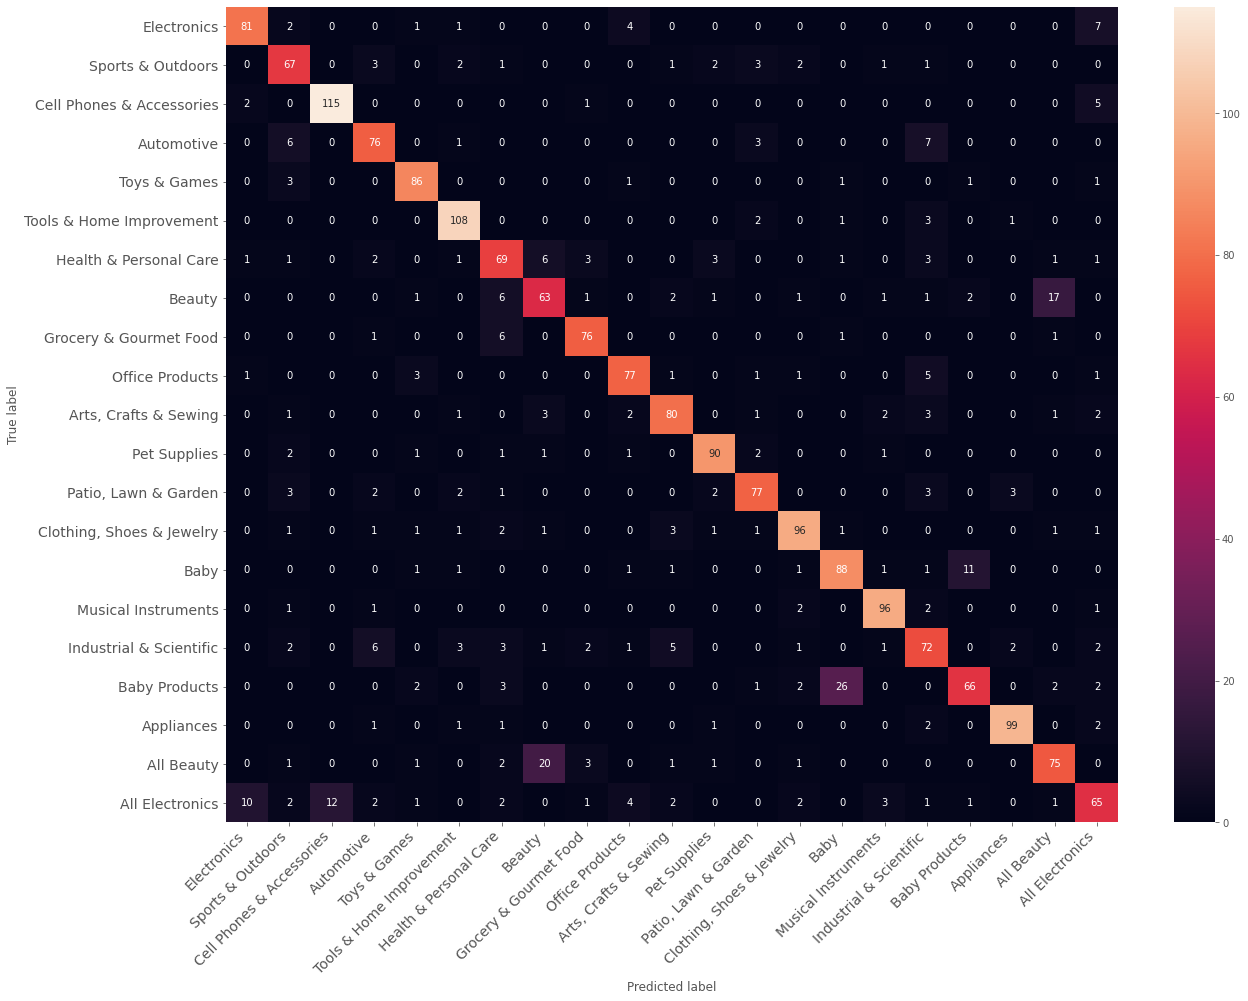

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

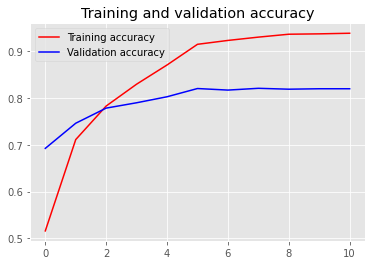

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

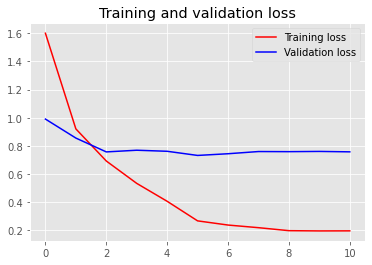

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 4.2 BERT and Sequential Keras

### small_bert/bert_en_uncased_L-2_H-768_A-12

In [ ]:
predictions = final_model.predict([text_test, image_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

2100/2100 - 15s


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, classes)
accuracy = accuracy_score(y_test, classes)
print(accuracy)

0.8214285714285714


Text(0.5, 114.0, 'Predicted label')

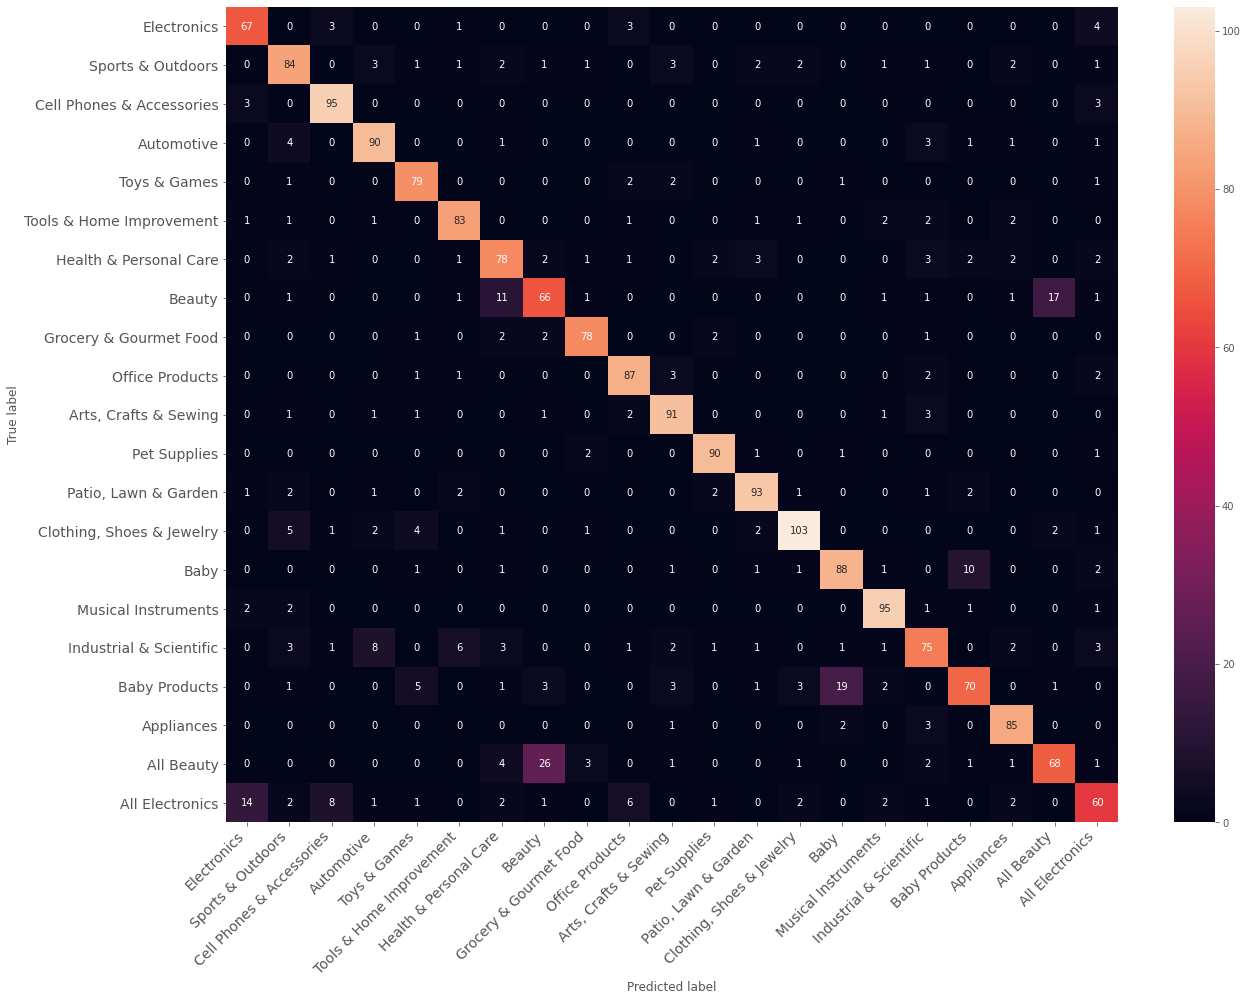

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

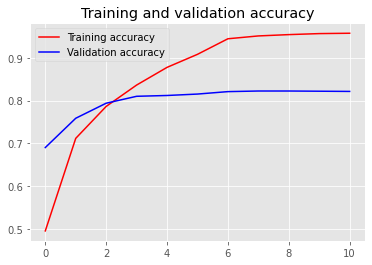

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

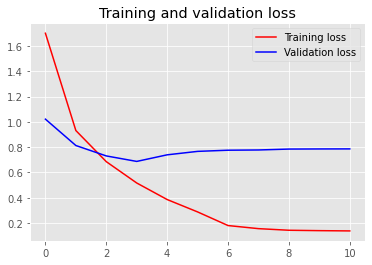

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### small_bert/bert_en_uncased_L-4_H-512_A-8

In [ ]:
predictions = final_model.predict([text_test, image_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

2100/2100 - 17s


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, classes)
accuracy = accuracy_score(y_test, classes)
print(accuracy)

0.8295238095238096


Text(0.5, 114.0, 'Predicted label')

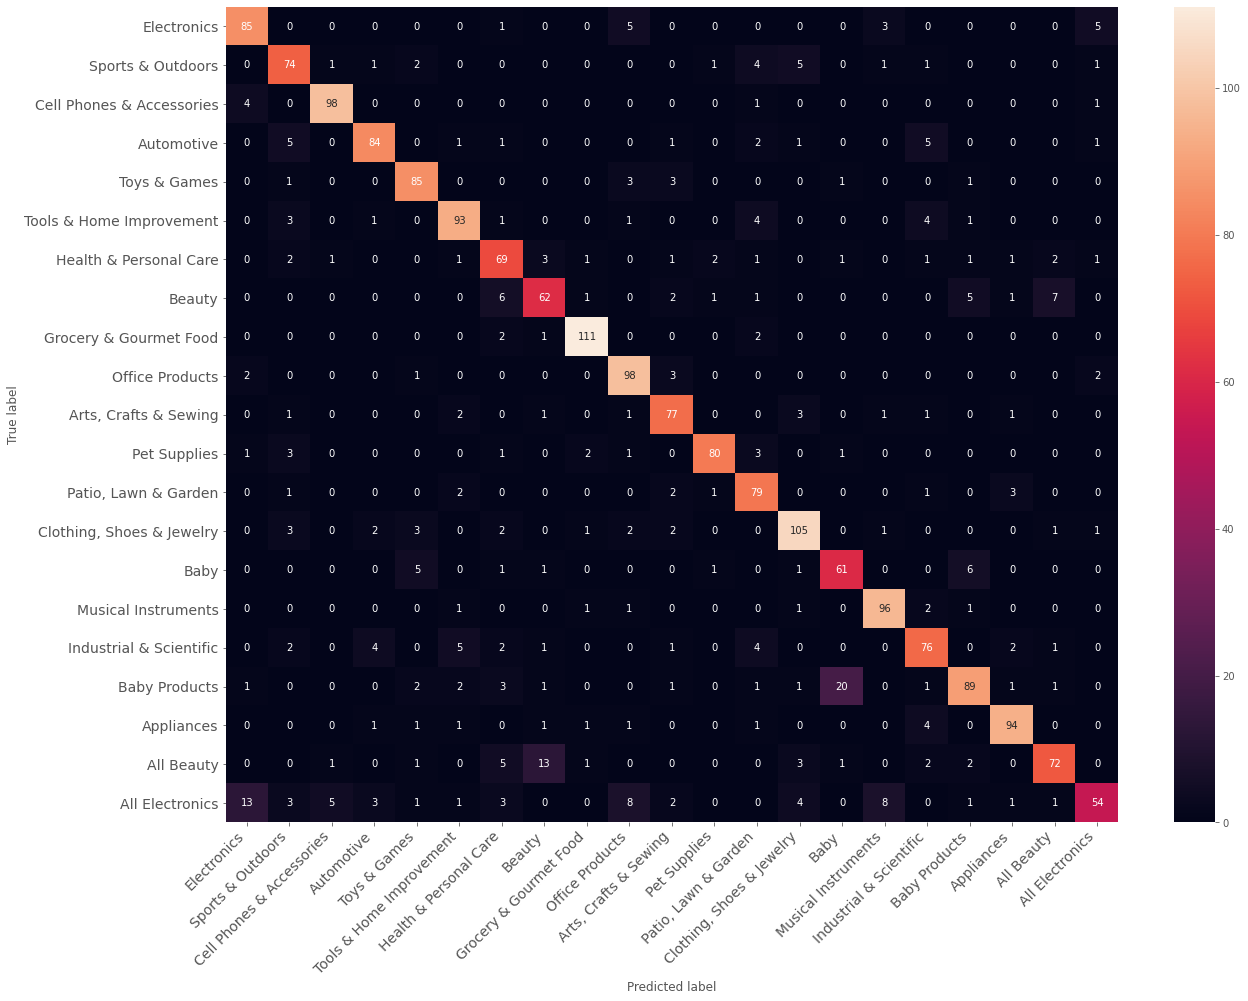

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

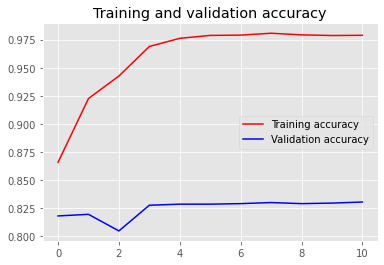

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

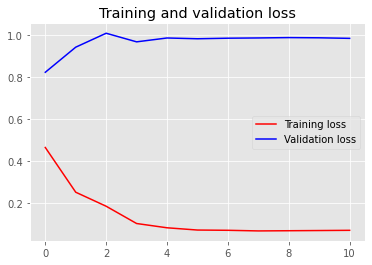

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###  small_bert/bert_en_uncased_L-4_H-768_A-12

In [ ]:
predictions = final_model.predict([text_test, image_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

2100/2100 - 16s


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, classes)
accuracy = accuracy_score(y_test, classes)
print(accuracy)

0.83


Text(0.5, 114.0, 'Predicted label')

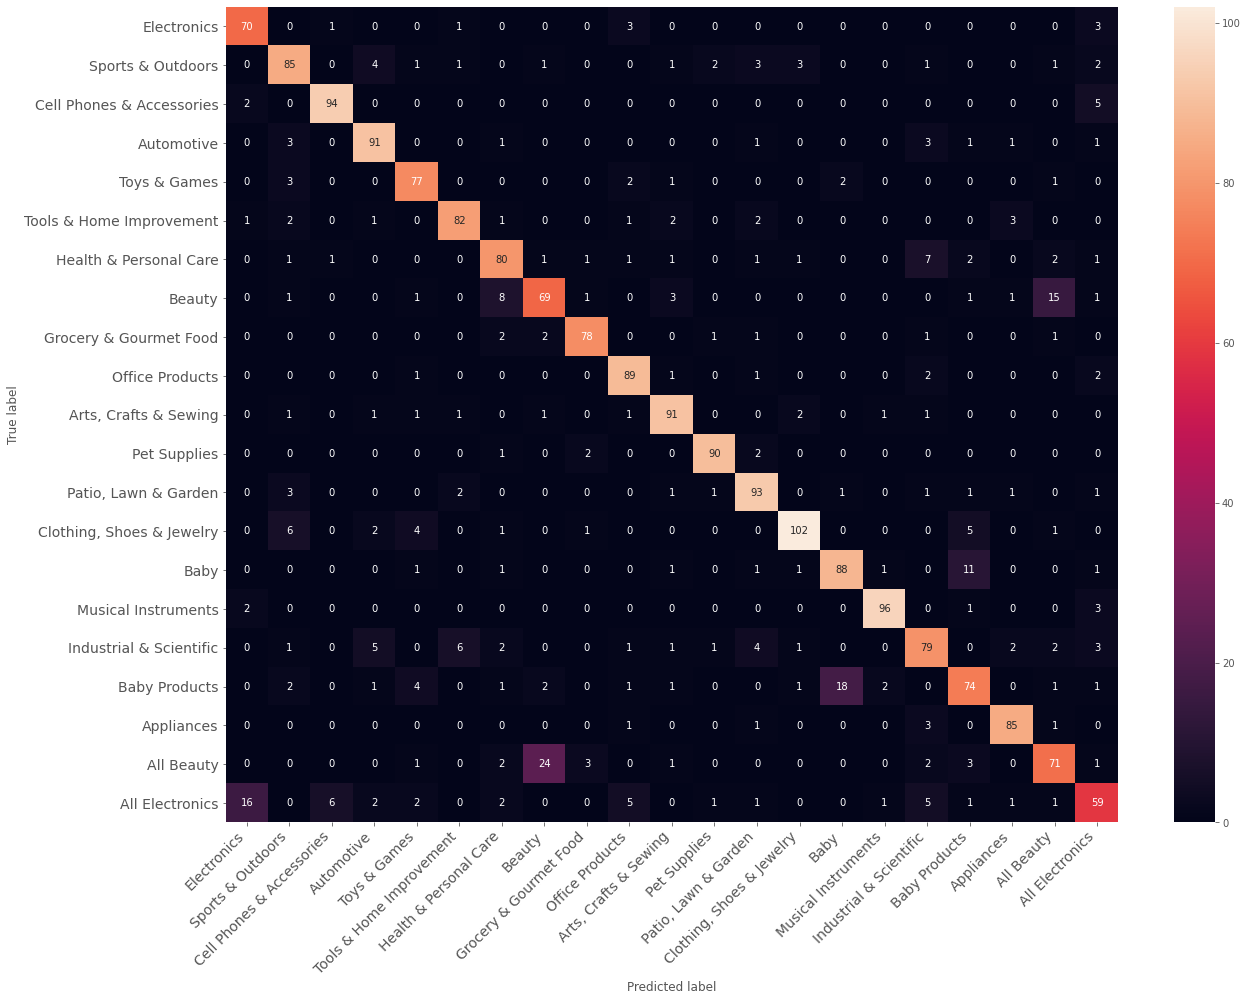

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

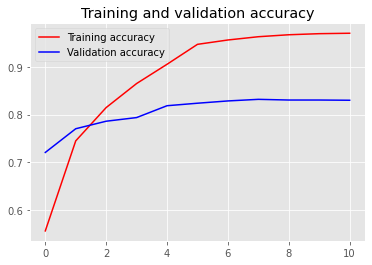

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

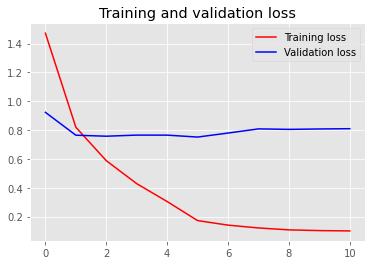

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###  small_bert/bert_en_uncased_L-12_H-512_A-8

In [ ]:
predictions = final_model.predict([text_test, image_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

2100/2100 - 26s


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, classes)
accuracy = accuracy_score(y_test, classes)
print(accuracy)

0.8338095238095238


Text(0.5, 114.0, 'Predicted label')

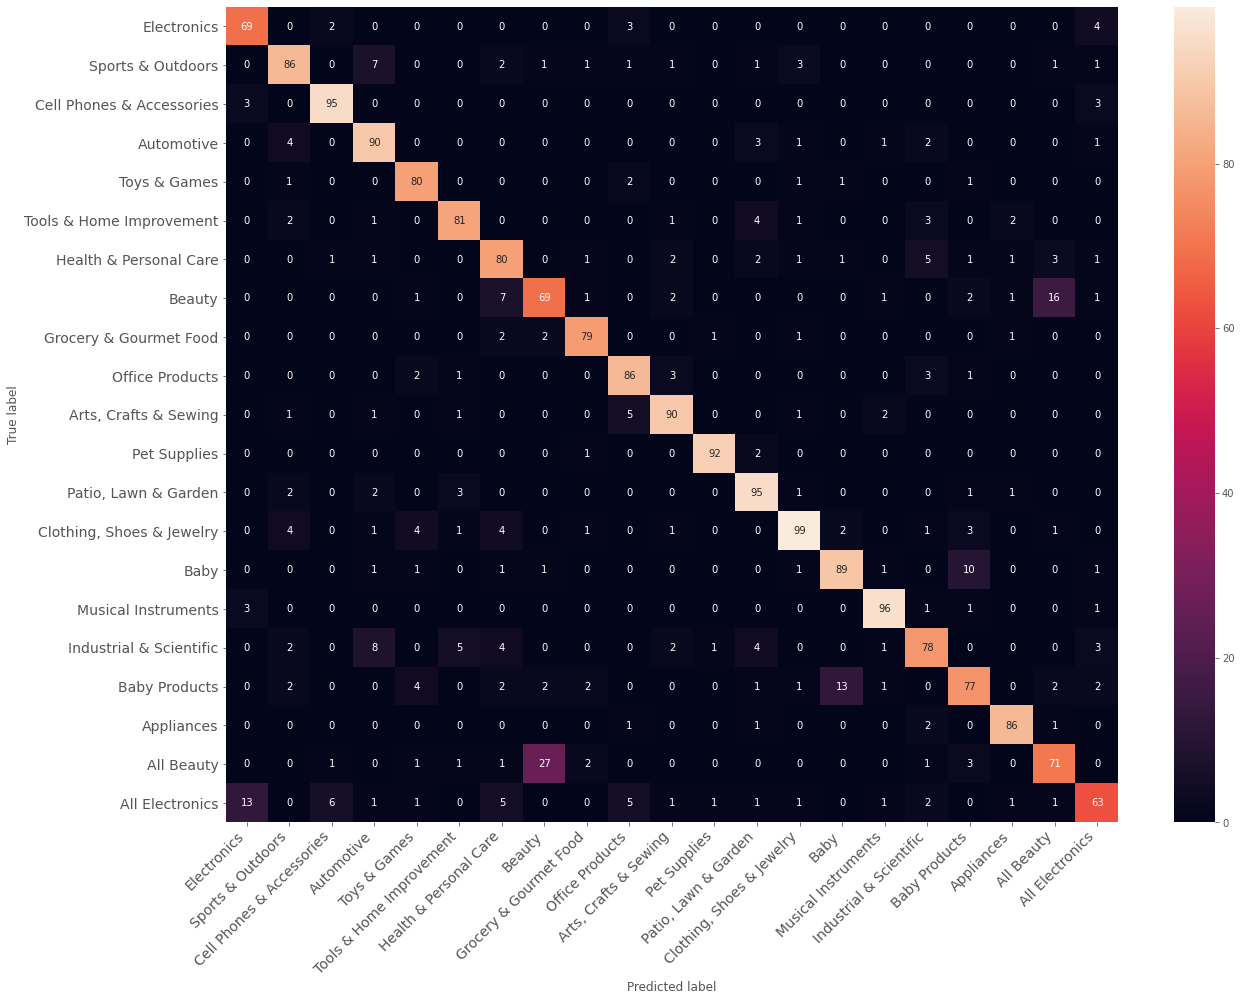

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

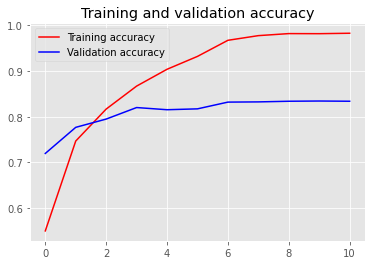

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

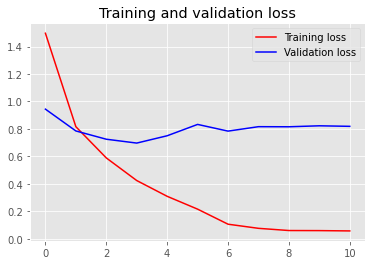

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
predictions = final_model.predict([text_test, image_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

2100/2100 - 26s


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, classes)
accuracy = accuracy_score(y_test, classes)
print(accuracy)

0.8338095238095238


Text(0.5, 114.0, 'Predicted label')

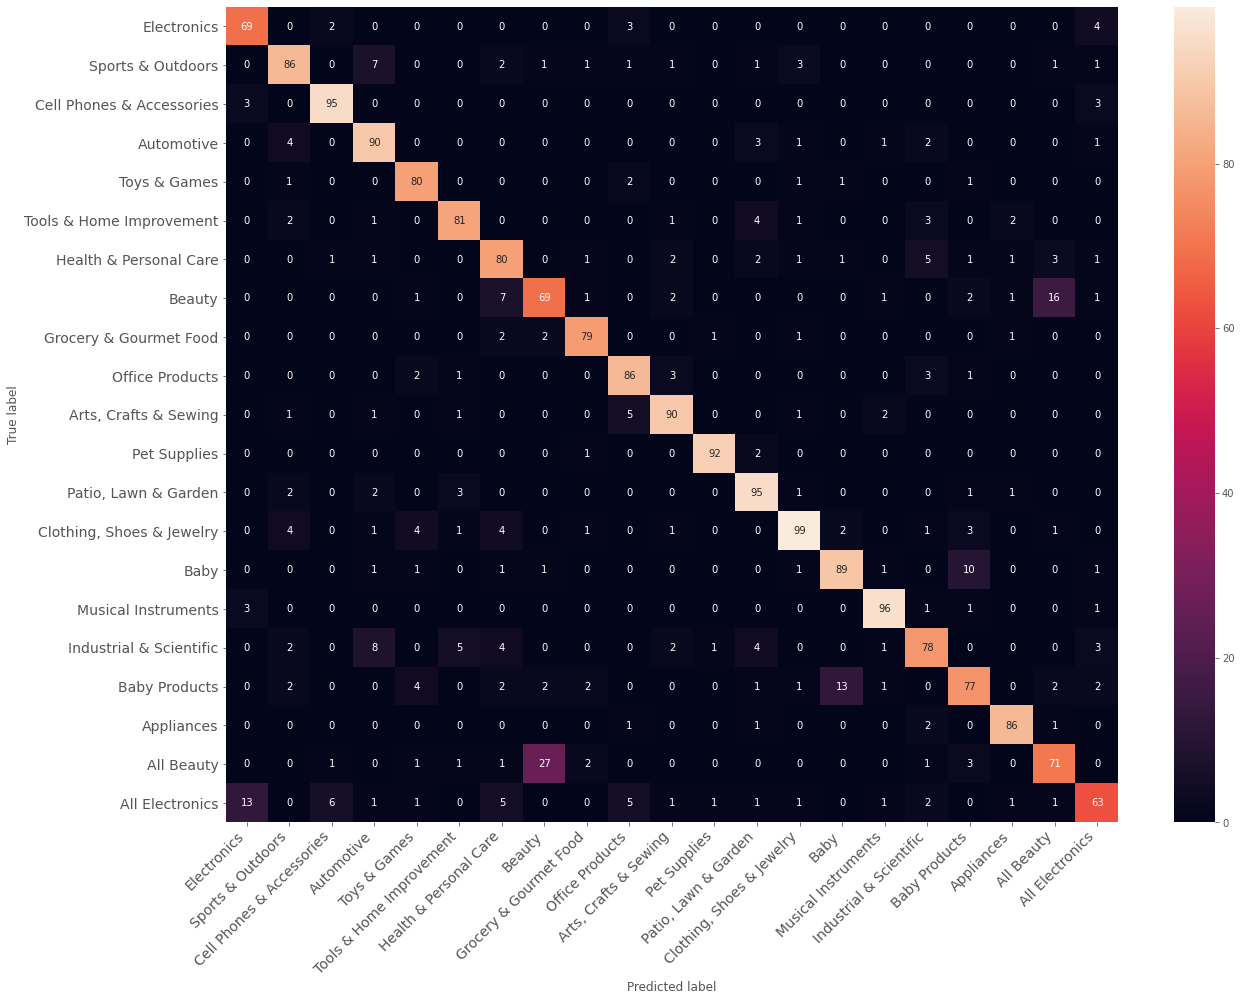

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

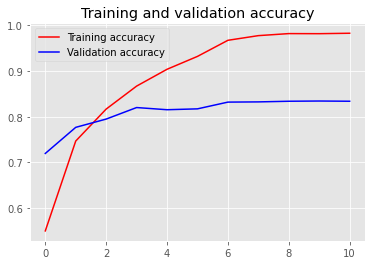

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

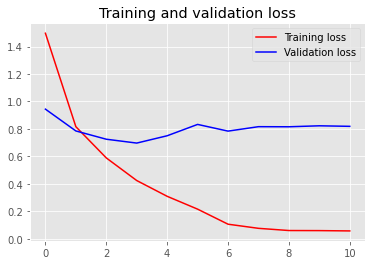

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 4.3 BERT and GoogleNet

small_bert/bert_en_uncased_L-4_H-512_A-8

In [ ]:
predictions = final_model.predict([text_test, image_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

2100/2100 - 47s


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, classes)
accuracy = accuracy_score(y_test, classes)
print(accuracy)

0.8333333333333334


Text(0.5, 114.0, 'Predicted label')

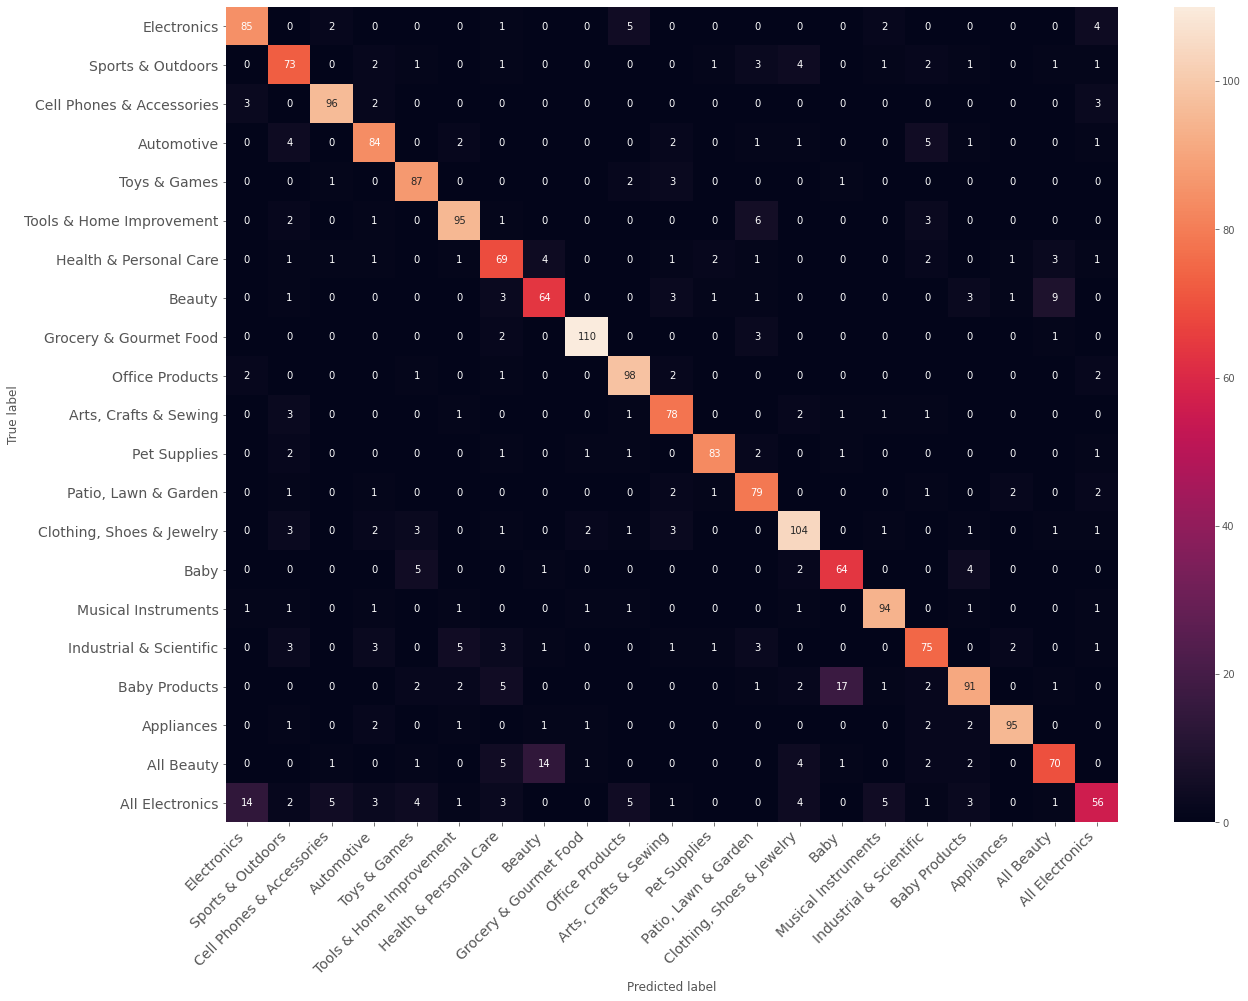

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

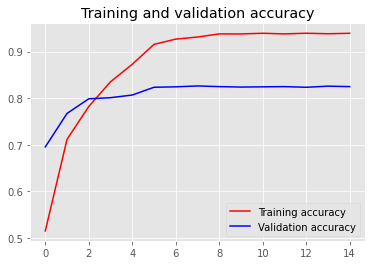

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

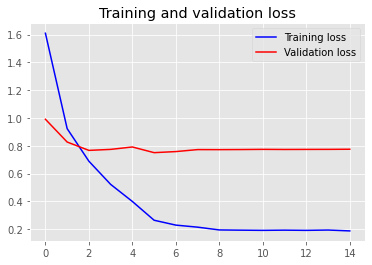

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 5 Submission


In [ ]:
del image_train
del image_test
del label_train
del label_test
del text_train
del text_test
del images
del data

In [ ]:
'''
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(get_token(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(corpus)
#sequences=tokenizer_obj.texts_to_sequences(corpus)
#tokenizer_obj=Tokenizer()
sequences=tokenizer_obj.texts_to_sequences(test_corpus)
test_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)
'''

## 5.1 Read the test data

In [ ]:
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head(10)

ImgId  ...                                        description
0  B0006IK25E  ...  Jacquard Textile Pink Color in 2.25 ounces can...
1  B000GBRO16  ...  Fimo Soft Polymer Clay is easier to use than b...
2  B000H6OZGW  ...  Sculpey 3 Polymer Clay is America's original o...
3  B000BR28KC  ...  Handmade since 1900 Sennelier extra-fine soft ...
4  B0006IK27M  ...  JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5  B0000AZ6NS  ...  Elastomeric marine sealant. One part, fast ski...
6  B0006IK268  ...  JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7  B000FNDZN6  ...  Permanent Fabric Dye will not fade or wash awa...
8  B000GBO8UG  ...  Fimo Soft Polymer Clay is easier to use than b...
9  B0006IK2FE  ...  JACQUARD TEXTILE COLORS FABRIC PAINT - These e...

[10 rows x 3 columns]

In [ ]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [ ]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(filter_description(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(corpus)
#sequences=tokenizer_obj.texts_to_sequences(corpus)
#tokenizer_obj=Tokenizer()
#sequences=tokenizer_obj.texts_to_sequences(test_corpus)
#test_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
test_corpus = np.asarray(test_corpus)
test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

## 5.2 Make predictions on test data

In [ ]:
pred = final_model.predict([test_corpus, test_images],batch_size=1,verbose = 2)
test_classes = np.argmax(pred, axis = 1)

6367/6367 - 43s


## 5.3 Create submission file

In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])